# Predicting housing prices: Model selection & analysis

## Project summary

This project was completed as part of the Kaggle competition [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). **The goal is to build a model for predicting house prices**.

The dataset comes from the Ames Housing Data project, which collected information on homes in Ames, Iowa from 2006 to 2010. The target variable is $SalesPrice$, the price paid for each home. Each of the 2,919 observations represent the sale of an individual home, and contains 81 features useful for appraising the value of each home.

## About this notebook

In this notebook, I take the clean and preprocessed data, assess different potential predictive models on the training set, and once a final model is selected, assess its predictive performance on the test set. The final predictions are saved for Kaggle. 

I implement 5-fold cross-validation when building models and assessing their performance. 5 folds seems like an adequate number given the moderate dataset size (only about 1,450 observations in the training set). The general approach is summarized as follows:
1. Use a grid search (with 5-fold cross-validation) to select the best set of hyperparameter values per candidate model/algorithm (see below) where relevant.
2. Use the best set of hyperparameters and refit to the full training set to obtain prediction accuracy criteria which be used to select the best model/algorithm.
2. Once a final model is chosen, predictions are made using the test set. Since $SalesPrice$ was log-transformed, the predictions are exponentiated to get them back to their original scale.

## Candidate models & performance criterion

Since we're predicting $SalesPrice$, a continuous variable, the following models/algorithms are selected as candidates:
- **Linear regression**: This simple model serves as a baseline.
- **Ridge regression**: With a large number of features, ridge regression might serve well to suppress features that aren't important for predicting final sales price.
- **Random forest**: Given the large number of features and the complex relationships that might exist, a random forest algorithm has the added bonus (compared to ridge regression) of not imposing a parametric structure. That is, we let the algorithm find the functional form.
- **Gradient boosting**: This model was selected for reasons similar to the random forest. It tends to be effective when modeling complex data. My guess is that it will be overkill and not any better than simpler models since the relationship between the target and feature variables seems relatively straightforward. 

Again, since the target variable is continuous, a natural criterion to capture predictive performance is the **mean squared error (MSE)**. I'll actually use the square root of MSE, **RMSE**, since it's on the scale of the data.

In [1]:
# begin by importing all necessary libraries for this notebook:

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# for fit criteria
from sklearn.metrics import mean_squared_error, r2_score

# for performing a grid search
from sklearn.model_selection import GridSearchCV

# for CV
from sklearn.model_selection import cross_val_score

# for linear regression
from sklearn import linear_model

# for ridge regression
from sklearn.linear_model import Ridge

# for random forest
from sklearn.ensemble import RandomForestRegressor

# for inline plotting:

%matplotlib inline

In [2]:
# open clean data

with open("final_adj_housingData.pickle", "rb") as f:
    X_train_adj,y_train,X_test_adj = pickle.load(f) 

The following function *display_scores()* was written to summarize the results of performing K-fold cross validation. It takes the resulting K performance scores and outputs the: (1) K scores, (2) average of the K scores, and (3) standard deviation of the K scores.  

In [3]:
## little helper function to print results

def display_scores(scores):
    scores_star = [ '%.4f' % elem for elem in scores ]
    print("Mean scores in each fold:", scores_star)
    print("Mean score across folds:", round(scores.mean(),4))
    print("Standard deviation of scores across folds:", round(scores.std(),4))

## Model selection

**Note that the scoring function within cross_val_score() is set so that higher values denote better performance (i.e., we get the -MSE). I transform these so that I can work with the traditional MSE where higher values denote worse performance.**

### Baseline model: Linear regression

In [4]:
# create linear regression object

regr = linear_model.LinearRegression()

# using 10-fold cross validation

linReg_scores = cross_val_score(estimator=regr, 
                                cv=10, 
                                X=X_train_adj, y=y_train,
                                scoring='neg_mean_squared_error')

In [5]:
## remember: -MSE, so bigger is *better*
## to convert to RMSE: -sqrt(-MSE)

linReg_rmse_scores = np.sqrt(-linReg_scores)

display_scores(linReg_rmse_scores)

Mean scores in each fold: ['0.0923', '0.0959', '0.0793', '0.1008', '0.1089', '0.0772', '0.0894', '0.0714', '0.0997', '0.3186']
Mean score across folds: 0.1134
Standard deviation of scores across folds: 0.0693


#### Linear regression results

The average RMSE across model fittings is 0.113 with a standard deviation of 0.069. The standard deviation is relatively high, and looking at the individual scores reveals that it's due to the 10th fold, which has an average MSE score of 0.32.

### Ridge regression

In [6]:
# create linear regression object

ridge_reg = Ridge()

# hyperparameter (alpha) values to investigate in the grid search

param_grid_ridge = {'alpha': [1e-15, 1e-10, 1e-8, 1e-4, 1e-3,1e-2, 1, 5, 10, 20]}

# grid search object

ridgeReg_grid = GridSearchCV(estimator = ridge_reg, 
                            param_grid=param_grid_ridge, 
                            cv = 5, 
                            scoring='neg_mean_squared_error')

# Fit the random search model

ridgeReg_grid.fit(X_train_adj, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [1e-15, 1e-10, 1e-08, 0.0001, 0.001, 0.01, 1, 5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

The best value of alpha is 5:

In [7]:
# reveal best estimate of alpha

ridgeReg_grid.best_params_

{'alpha': 5}

Refit ridge regression using alpha = 5 on the full training set:

In [8]:
# refit to full training set with best estimator

ridge_reg = Ridge(alpha=5)
ridgeReg_scores = cross_val_score(estimator=ridge_reg, 
                                cv=10, 
                                X=X_train_adj, y=y_train,
                                scoring='neg_mean_squared_error')

In [9]:
## remember: -MSE, so bigger is *better*
## to convert to RMSE: -sqrt(-MSE)

rRidgeReg_rmse_scores = np.sqrt(-ridgeReg_scores)

display_scores(rRidgeReg_rmse_scores)

Mean scores in each fold: ['0.0831', '0.0618', '0.0709', '0.0947', '0.1020', '0.0705', '0.0882', '0.0680', '0.0862', '0.0801']
Mean score across folds: 0.0805
Standard deviation of scores across folds: 0.0121


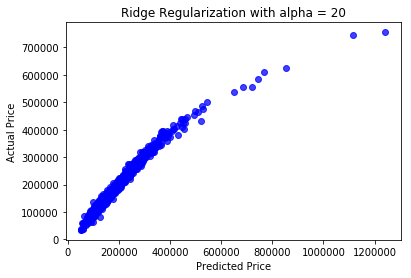

In [10]:
final_model = ridgeReg_grid.best_estimator_
rRidgeReg_pred = np.exp(final_model.predict(X_train_adj))

plt.scatter(rRidgeReg_pred, np.exp(y_train), alpha=.75, color='b')
plt.xlabel('Predicted Price')
plt.ylabel('Actual Price')
plt.title('Ridge Regularization with alpha = 20')
plt.show()

#### Summary of ridge regression

The average RMSE across model fittings is 0.081 with a standard deviation of 0.012. Compared to using linear regression, Ridge regression outperforms linear regression, and has a much smaller standard deviation.

### Random forest

In [11]:
forest_reg = RandomForestRegressor()

param_grid_forest = {'n_estimators' : [10,50,100,150,200],
                     'max_depth': [10,20,30,40,50]}

In [12]:
# grid search to find best max_depth hyperparamter value

forestReg_grid = GridSearchCV(estimator = forest_reg, 
                            param_grid=param_grid_forest, 
                            cv = 5, 
                            scoring='neg_mean_squared_error')

# Fit the random search model
forestReg_grid.fit(X_train_adj, y_train.values.ravel())

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [10, 50, 100, 150, 200], 'max_depth': [10, 20, 30, 40, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [13]:
forestReg_grid.best_params_

{'max_depth': 50, 'n_estimators': 200}

Refit random forest using max_depth = 25 and n_estimators = 50 on the full training set:

In [14]:
# refit with best estimator

forest_reg = RandomForestRegressor(n_estimators=50, max_depth=25)

forestReg_scores = cross_val_score(estimator=forest_reg, 
                                cv=5, 
                                X=X_train_adj, y=y_train.values.ravel(),
                                scoring='neg_mean_squared_error')

#pickle.dump(forestReg_scores, 'saved_fullTrainedForest.pkl') 

In [15]:
## remember: -MSE, so bigger is *better*
## to convert to RMSE: -sqrt(-MSE)

forestReg_rmse_scores = np.sqrt(-forestReg_scores)

display_scores(forestReg_rmse_scores)

Mean scores in each fold: ['0.0050', '0.0138', '0.0145', '0.0176', '0.0120']
Mean score across folds: 0.0126
Standard deviation of scores across folds: 0.0042


#### Summary of random forest

The average RMSE across model fittings is 0.014 with a standard deviation of 0.004. Compared to using ridge regression, the random forest algorithm outperforms ridge regression. Both the average RMSE and variation across folds is smaller. 

## Final model: Random forest

In [16]:
## eval on test set using random forest
final_model = forestReg_grid.best_estimator_
y_hat_log = final_model.predict(X_test_adj)
y_hat = np.exp(y_hat_log)

In [17]:
## prep for submission
t = pd.read_csv('./test.csv') # i need Id
submission = pd.DataFrame()
submission['Id'] = t.Id
submission['SalePrice'] = y_hat
submission.head()

,Id,SalePrice
0,1461,162967.121698
1,1462,162930.864292
2,1463,162992.212805
3,1464,162960.606555
4,1465,162876.841936


In [18]:
submission.to_csv('submission1.csv', index=False)